**Step 1: Simulation Overview and Environment Setup**

We'll begin by outlining the simulation workflow and preparing the Google Colab environment for both the traditional and AI-enhanced aggregate batching process. This first step ensures all necessary libraries are installed and the problem context is clear.

**1.1 Simulation Workflow Description**

**Objective:**

Simulate the aggregate batching process for three scenarios (estimated = actual, estimated > actual, estimated < actual flow rates) using both the traditional control method and the proposed LSTM + RL-based intelligent control. This will allow for a direct comparison of key performance metrics.

**Simulation Structure:**

**Section 1:** Data and library setup

**Section 2:** Traditional batching process simulation

**Section 3:** LSTM-based flow prediction model

**Section 4:** RL-based controller self-tuning

**Section 5:** Combined intelligent control simulation

**Section 6:** Results comparison and visualization

**Description:**

This cell installs and imports all necessary Python libraries for simulation, deep learning (LSTM), and reinforcement learning (RL). It also sets random seeds for reproducibility. After running this cell, the environment will be ready for data generation and model development.

**1. Environment Setup and Data Loading**

**1.1 Install and Import Required Libraries**

In [144]:
# Cell 1: Install and import required libraries

# Install deep learning and RL libraries if not already present
!pip install tensorflow==2.15.0 keras==2.15.0 stable-baselines3==2.2.1 --quiet

# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from stable_baselines3 import DQN
import gym
import random

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Libraries installed and imported successfully.")



Libraries installed and imported successfully.


**Step 2: Data Generation and Traditional Batching Process Simulation**

**Overview**

Now that the environment setup is complete with all necessary libraries installed and imported, we will proceed to generate synthetic data representing the aggregate flow rates and weights. This data will serve as the basis for simulating the traditional batching process as described in Chapter 7 of your thesis.

The traditional batching simulation will replicate the control logic where the estimated flow rate is used to calculate gate open times, and the batch weight is adjusted over multiple cycles until the target weight is reached.

**2.1 Notebook Cell: Generate Synthetic Aggregate Flow Rate and Weight Data**

**Description**

This cell creates three scenarios reflecting the relationship between estimated and actual flow rates.

For each scenario, it generates a small set of synthetic actual flow rates with slight random variation to mimic real industrial conditions.

The output prints the actual flow rates for each cycle in each scenario for your review.

In [145]:
# Cell 2: Generate synthetic data for aggregate flow rates and batch weights

import numpy as np

# Parameters
target_weight = 1000  # Target batch weight in kg
num_cycles = 4        # Number of batching cycles per scenario

# Define three scenarios for flow rates (kg/s)
scenarios = {
    "equal_flow_rate": 5.5,   # Estimated = Actual flow rate
    "higher_estimated": 6.0,  # Estimated > Actual flow rate
    "lower_estimated": 5.0    # Estimated < Actual flow rate
}

# Generate synthetic actual flow rates for each cycle (simulate slight variations)
np.random.seed(42)
actual_flow_rates = {
    "equal_flow_rate": np.random.normal(loc=5.5, scale=0.1, size=num_cycles),
    "higher_estimated": np.random.normal(loc=5.0, scale=0.1, size=num_cycles),
    "lower_estimated": np.random.normal(loc=6.0, scale=0.1, size=num_cycles)
}

# Display generated actual flow rates for review
for scenario, flows in actual_flow_rates.items():
    print(f"{scenario} actual flow rates (kg/s): {flows}")


equal_flow_rate actual flow rates (kg/s): [5.54967142 5.48617357 5.56476885 5.65230299]
higher_estimated actual flow rates (kg/s): [4.97658466 4.9765863  5.15792128 5.07674347]
lower_estimated actual flow rates (kg/s): [5.95305256 6.054256   5.95365823 5.95342702]


**Step 3: Implement Traditional Batching Process Simulation**

In this step, we will implement the traditional aggregate batching process simulation using the synthetic flow rate data generated previously. The simulation will model the batching cycles for each scenario and calculate the cumulative weight, weight errors, and other relevant metrics

**3.1 Notebook Cell: Traditional Batching Simulation Function**

**Description**

This cell defines a function to simulate the traditional batching process for any scenario.

It computes, for each cycle:
* The weight error (how much more is needed, using a 75% correction factor).
* The gate open time (based on the estimated flow rate).
* The actual weight added (using the true flow rate for that cycle).
* The cumulative and remaining weight to target.

The results for each scenario are displayed as tables for review.

In [146]:
# Cell 3: Simulate traditional batching process for each scenario

def traditional_batching_simulation(actual_flows, estimated_flow, target_weight=1000, num_cycles=4):
    results = []
    cumulative_weight = 0
    for i in range(num_cycles):
        # Calculate weight error (75% of remaining difference to target)
        weight_error = (target_weight - cumulative_weight) * 0.75
        # Calculate gate open time using estimated flow rate
        gate_open_time = weight_error / estimated_flow
        # Actual weight added using actual flow rate for this cycle
        actual_weight_added = actual_flows[i] * gate_open_time
        cumulative_weight += actual_weight_added
        # Remaining weight to target
        weight_to_target = target_weight - cumulative_weight
        results.append({
            'Cycle': i + 1,
            'Weight Error (kg)': round(weight_error, 2),
            'Gate Open Time (s)': round(gate_open_time, 2),
            'Actual Weight Added (kg)': round(actual_weight_added, 2),
            'Cumulative Weight (kg)': round(cumulative_weight, 2),
            'Weight to Target (kg)': round(weight_to_target, 2)
        })
    return results

# Define estimated flow rates for each scenario
estimated_flows = {
    "equal_flow_rate": 5.5,
    "higher_estimated": 6.0,
    "lower_estimated": 5.0
}

# Run simulation for each scenario
simulation_results = {}
for scenario in actual_flow_rates:
    simulation_results[scenario] = traditional_batching_simulation(
        actual_flows=actual_flow_rates[scenario],
        estimated_flow=estimated_flows[scenario]
    )

# Display results for each scenario
for scenario, results in simulation_results.items():
    print(f"\nScenario: {scenario.replace('_', ' ').title()}")
    df = pd.DataFrame(results)
    print(df)



Scenario: Equal Flow Rate
   Cycle  Weight Error (kg)  Gate Open Time (s)  Actual Weight Added (kg)  \
0      1             750.00              136.36                    756.77   
1      2             182.42               33.17                    181.96   
2      3              45.95                8.35                     46.49   
3      4              11.08                2.01                     11.39   

   Cumulative Weight (kg)  Weight to Target (kg)  
0                  756.77                 243.23  
1                  938.73                  61.27  
2                  985.22                  14.78  
3                  996.61                   3.39  

Scenario: Higher Estimated
   Cycle  Weight Error (kg)  Gate Open Time (s)  Actual Weight Added (kg)  \
0      1             750.00              125.00                    622.07   
1      2             283.45               47.24                    235.10   
2      3             107.12               17.85                     92.09

**Step 4: LSTM-Based Flow Prediction Model Implementation**

In this step, we will implement an LSTM model to predict aggregate flow rates based on historical data. This model will enhance the simulation by providing adaptive, data-driven flow rate estimates for each batching cycle, which can then be compared to traditional static estimates.

**4.1 Notebook Cell: Prepare Data for LSTM Model**
**Description:**

* This cell prepares the flow rate data for LSTM training by scaling and converting it into sequences suitable for time-series forecasting.

* The create_sequences function generates input-output pairs for supervised learning, where each input is a window of previous flow rates and the output is the next flow rate.

In [147]:
# Cell 4: Prepare time series data for LSTM flow prediction

from sklearn.preprocessing import MinMaxScaler

# Combine all actual flow rates into a single time series for demonstration
flow_series = np.concatenate([
    actual_flow_rates['equal_flow_rate'],
    actual_flow_rates['higher_estimated'],
    actual_flow_rates['lower_estimated']
])

# Reshape and scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
flow_series_scaled = scaler.fit_transform(flow_series.reshape(-1, 1))

# Create sequences for LSTM (windowed time series)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 2  # Number of previous steps to use for prediction
X, y = create_sequences(flow_series_scaled, seq_length)

print(f"Input shape for LSTM: {X.shape}")
print(f"Output shape for LSTM: {y.shape}")


Input shape for LSTM: (10, 2, 1)
Output shape for LSTM: (10, 1)


**4.2 Notebook Cell: Build and Train the LSTM Model**

**Description:**

This cell defines a simple LSTM network with one LSTM layer and one Dense output layer.

The model is trained on the prepared sequences for 100 epochs.

Training output confirms successful model fitting.

In [148]:
# Cell 5: Build and train the LSTM model for flow prediction

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential([
    LSTM(32, input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=100, batch_size=2, verbose=0)

print("LSTM model trained successfully.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


LSTM model trained successfully.


**4.3 Notebook Cell: Predict Flow Rates Using the LSTM Model**

**Description:**

* This cell uses the trained LSTM model to predict the next aggregate flow rate based on the most recent data.

* The predicted value is inverse-transformed to the original scale for interpretability.

In [149]:
# Cell 6: Predict flow rates for the next batching cycles using the trained LSTM

# Predict on the last available sequence
last_sequence = flow_series_scaled[-seq_length:].reshape(1, seq_length, 1)
predicted_scaled = model.predict(last_sequence)
predicted_flow = scaler.inverse_transform(predicted_scaled)[0][0]

print(f"Predicted next flow rate (kg/s): {predicted_flow:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Predicted next flow rate (kg/s): 5.81


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  


**Step 5: Integrate LSTM Flow Predictions into Batching Simulation**

With the LSTM model trained and able to predict future flow rates, the next step is to use these predictions within the batching process simulation. This integration demonstrates how adaptive, data-driven flow rate estimation can improve batching accuracy and efficiency compared to the traditional static approach.

**5.1 Notebook Cell: Simulate Batching Using LSTM-Predicted Flow Rates**

**Description**
* This cell defines a function to simulate the batching process using LSTM-predicted flow rates for each cycle.

* The predicted flow is used to compute the gate open time, and the actual weight added is based on the real flow rate for fair comparison.

* Results are printed in a table for review.

In [150]:
# Cell 7: Simulate batching process using LSTM-predicted flow rates

def intelligent_batching_simulation(lstm_model, scaler, initial_flows, target_weight=1000, num_cycles=4, seq_length=2):
    results = []
    cumulative_weight = 0
    flow_history = list(initial_flows[:seq_length])  # Start with initial real flow data

    for i in range(num_cycles):
        # Prepare input for LSTM: last 'seq_length' flow rates, scaled
        input_seq = scaler.transform(np.array(flow_history[-seq_length:]).reshape(-1, 1)).reshape(1, seq_length, 1)
        # Predict next flow rate
        predicted_scaled = lstm_model.predict(input_seq, verbose=0)
        predicted_flow = scaler.inverse_transform(predicted_scaled)[0][0]
        # Calculate weight error (75% of remaining difference to target)
        weight_error = (target_weight - cumulative_weight) * 0.75
        # Gate open time using predicted flow rate
        gate_open_time = weight_error / predicted_flow
        # Simulate actual weight added (using true flow rate for realism)
        actual_flow = initial_flows[i]  # For fair comparison, use actual flow
        actual_weight_added = actual_flow * gate_open_time
        cumulative_weight += actual_weight_added
        weight_to_target = target_weight - cumulative_weight
        results.append({
            'Cycle': i + 1,
            'LSTM Predicted Flow (kg/s)': round(predicted_flow, 2),
            'Weight Error (kg)': round(weight_error, 2),
            'Gate Open Time (s)': round(gate_open_time, 2),
            'Actual Weight Added (kg)': round(actual_weight_added, 2),
            'Cumulative Weight (kg)': round(cumulative_weight, 2),
            'Weight to Target (kg)': round(weight_to_target, 2)
        })
        # Add the new actual flow to history for next prediction
        flow_history.append(actual_flow)
    return results

# Example: Run intelligent batching simulation for the "equal_flow_rate" scenario
intelligent_results = intelligent_batching_simulation(
    lstm_model=model,
    scaler=scaler,
    initial_flows=actual_flow_rates['equal_flow_rate'],
    target_weight=1000,
    num_cycles=4,
    seq_length=seq_length
)

# Display results
df_intelligent = pd.DataFrame(intelligent_results)
print("Intelligent (LSTM-based) Batching Simulation Results:")
print(df_intelligent)


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  


Intelligent (LSTM-based) Batching Simulation Results:
   Cycle  LSTM Predicted Flow (kg/s)  Weight Error (kg)  Gate Open Time (s)  \
0      1                        5.55             750.00          135.199997   
1      2                        5.56             187.26           33.690000   
2      3                        5.55              48.63            8.770000   
3      4                        5.56              12.04            2.160000   

   Actual Weight Added (kg)  Cumulative Weight (kg)  Weight to Target (kg)  
0                    750.32                  750.32                 249.68  
1                    184.84                  935.16                  64.84  
2                     48.78                  983.94                  16.06  
3                     12.23                  996.18                   3.82  


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  


**Step 6: Reinforcement Learning (RL) Controller Self-Tuning Integration**

In this step, we will implement a basic RL agent to demonstrate self-tuning of controller parameters within the batching process simulation. This agent will learn to adjust a key parameter—such as the correction factor or gate open time—based on feedback from the process, aiming to minimize the batch error and number of cycles required to reach the target weight.

**6.1 Notebook Cell: Define a Simple RL Environment for Batching Control**

**Description:**

* This cell defines a custom OpenAI Gym environment simulating the batching process.

* The agent's action is the correction factor (how aggressively to correct the weight error).

* The environment returns observations, rewards, and tracks the process state for each cycle.

In [151]:
# Cell 8: Define a custom Gym environment for RL-based batching control

# import gym
import gymnasium as gym # Import gymnasium
from gymnasium import spaces # Import spaces from gymnasium

class BatchingEnv(gym.Env):
    def __init__(self, actual_flows, target_weight=1000, num_cycles=4):
        super(BatchingEnv, self).__init__()
        self.actual_flows = actual_flows
        self.target_weight = target_weight
        self.num_cycles = num_cycles
        self.current_cycle = 0
        self.cumulative_weight = 0
        # Action: Correction factor (continuous between 0.5 and 1.0)
        self.action_space = spaces.Box(low=0.5, high=1.0, shape=(1,), dtype=np.float32)
        # Observation: [cycle, cumulative_weight, last_flow]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([num_cycles, target_weight, 10]),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None): # Added seed and options parameters
        super().reset(seed=seed) # Added super().reset()
        self.current_cycle = 0
        self.cumulative_weight = 0
        self.last_flow = self.actual_flows[0]
        return np.array([self.current_cycle, self.cumulative_weight, self.last_flow], dtype=np.float32), {} # Added info dictionary

    def step(self, action):
        correction_factor = float(action[0])
        weight_error = (self.target_weight - self.cumulative_weight) * correction_factor
        gate_open_time = weight_error / self.last_flow
        actual_flow = self.actual_flows[self.current_cycle]
        actual_weight_added = actual_flow * gate_open_time
        self.cumulative_weight += actual_weight_added
        self.current_cycle += 1
        done = self.current_cycle >= self.num_cycles
        reward = -abs(self.target_weight - self.cumulative_weight)  # Negative error as reward
        obs = np.array([self.current_cycle, self.cumulative_weight, actual_flow], dtype=np.float32)
        self.last_flow = actual_flow
        return obs, reward, done, False, {} # Added truncated and info dictionary

    def render(self, mode='human'):
        print(f"Cycle: {self.current_cycle}, Cumulative Weight: {self.cumulative_weight:.2f}")

# Example usage:
env = BatchingEnv(actual_flows=actual_flow_rates['equal_flow_rate'])
obs, info = env.reset() # Unpack the observation and info dictionary
print("RL Environment initialized. Initial observation:", obs)

RL Environment initialized. Initial observation: [0.        0.        5.5496716]


**6.2 Notebook Cell: Train a Simple RL Agent (DQN) for Controller Tuning**

**Description:**

* This cell adapts the environment for discrete actions and trains a DQN agent to select the optimal correction factor for each cycle.

* The reward is based on minimizing the final batch error.

In [152]:
# Cell 9: Train a DQN agent to tune the correction factor in the batching process

from stable_baselines3 import DQN

# Wrap the environment for compatibility
from stable_baselines3.common.env_checker import check_env
# check_env(env, warn=True) # Commented out check_env as it's done in the previous cell

# DQN expects discrete actions, so we discretize the correction factor for demonstration
class DiscreteBatchingEnv(BatchingEnv):
    def __init__(self, actual_flows, target_weight=1000, num_cycles=4):
        super().__init__(actual_flows, target_weight, num_cycles)
        # Discrete action space: 0.5, 0.6, ..., 1.0
        self.action_space = spaces.Discrete(6)
        self.correction_factors = np.linspace(0.5, 1.0, 6)

    def step(self, action):
        correction_factor = self.correction_factors[action]
        weight_error = (self.target_weight - self.cumulative_weight) * correction_factor
        gate_open_time = weight_error / self.last_flow
        actual_flow = self.actual_flows[self.current_cycle]
        actual_weight_added = actual_flow * gate_open_time
        self.cumulative_weight += actual_weight_added
        self.current_cycle += 1
        done = self.current_cycle >= self.num_cycles
        reward = -abs(self.target_weight - self.cumulative_weight)
        obs = np.array([self.current_cycle, self.cumulative_weight, actual_flow], dtype=np.float32)
        self.last_flow = actual_flow
        return obs, reward, done, False, {} # Added truncated and info dictionary

# Instantiate and train the agent
rl_env = DiscreteBatchingEnv(actual_flows=actual_flow_rates['equal_flow_rate'])
model = DQN('MlpPolicy', rl_env, verbose=0)
model.learn(total_timesteps=2000)

print("RL agent trained for batching controller self-tuning.")

RL agent trained for batching controller self-tuning.


**6.3 Notebook Cell: Simulate RL-Based Batching and Compare Results**

**Description:**

* This cell simulates the batching process using the RL-tuned controller, logging key metrics for each cycle.

* Results are displayed in a table for comparison with the traditional and LSTM-based approaches.

In [153]:
# Cell 10: Simulate batching process using RL-tuned controller

def rl_batching_simulation(model, env, initial_flows, num_cycles=4):
    obs, _ = env.reset() # Unpack the observation
    results = []
    for i in range(num_cycles):
        action, _ = model.predict(obs, deterministic=True)
        correction_factor = env.correction_factors[action]
        weight_error = (env.target_weight - env.cumulative_weight) * correction_factor
        gate_open_time = weight_error / env.last_flow
        actual_flow = initial_flows[i]
        actual_weight_added = actual_flow * gate_open_time
        env.cumulative_weight += actual_weight_added
        weight_to_target = env.target_weight - env.cumulative_weight
        results.append({
            'Cycle': i + 1,
            'RL Correction Factor': round(correction_factor, 2),
            'Weight Error (kg)': round(weight_error, 2),
            'Gate Open Time (s)': round(gate_open_time, 2),
            'Actual Weight Added (kg)': round(actual_weight_added, 2),
            'Cumulative Weight (kg)': round(env.cumulative_weight, 2),
            'Weight to Target (kg)': round(weight_to_target, 2)
        })
        obs, _, done, _, _ = env.step(action) # Unpack the observation
        if done:
            break
    return results

# Run RL-based simulation for the "equal_flow_rate" scenario
rl_results = rl_batching_simulation(
    model=model,
    env=rl_env,
    initial_flows=actual_flow_rates['equal_flow_rate'],
    num_cycles=4
)

# Display results
df_rl = pd.DataFrame(rl_results)
print("RL-Based Batching Simulation Results:")
print(df_rl)

RL-Based Batching Simulation Results:
   Cycle  RL Correction Factor  Weight Error (kg)  Gate Open Time (s)  \
0      1                   0.8             800.00              144.15   
1      2                   0.9              36.00                6.49   
2      3                   0.9               0.44                0.08   
3      4                   0.9               0.00                0.00   

   Actual Weight Added (kg)  Cumulative Weight (kg)  Weight to Target (kg)  
0                    800.00                  800.00                 200.00  
1                     35.59                  995.59                   4.41  
2                      0.44                  999.96                   0.04  
3                      0.00                 1000.00                   0.00  



**Step 7: Results Visualization and Comparison**

In this step, we will visualize and compare the simulation results from the three control approaches implemented so far:
* Traditional batching control using static estimated flow rates
* Intelligent batching control using LSTM-based flow prediction
* Reinforcement Learning (RL)-based controller self-tuning

This comparison will help highlight the improvements in batching accuracy, efficiency, and adaptability achieved by integrating AI/ML techniques.

**7.1 Notebook Cell: Prepare Data for Visualization**

In [154]:
# Cell 11: Prepare dataframes for visualization comparison

# Convert results to DataFrames
df_traditional_equal = pd.DataFrame(simulation_results['equal_flow_rate'])
df_lstm_equal = pd.DataFrame(intelligent_results)
df_rl_equal = pd.DataFrame(rl_results)

# Add method labels for plotting
df_traditional_equal['Method'] = 'Traditional'
df_lstm_equal['Method'] = 'LSTM Prediction'
df_rl_equal['Method'] = 'RL Tuning'

# Select relevant columns for comparison
df_traditional_equal = df_traditional_equal[['Cycle', 'Weight to Target (kg)', 'Method']]
df_lstm_equal = df_lstm_equal[['Cycle', 'Weight to Target (kg)', 'Method']]
df_rl_equal = df_rl_equal[['Cycle', 'Weight to Target (kg)', 'Method']]

# Combine all data
df_comparison = pd.concat([df_traditional_equal, df_lstm_equal, df_rl_equal], ignore_index=True)


**7.2 Notebook Cell: Plot Weight to Target Over Cycles**

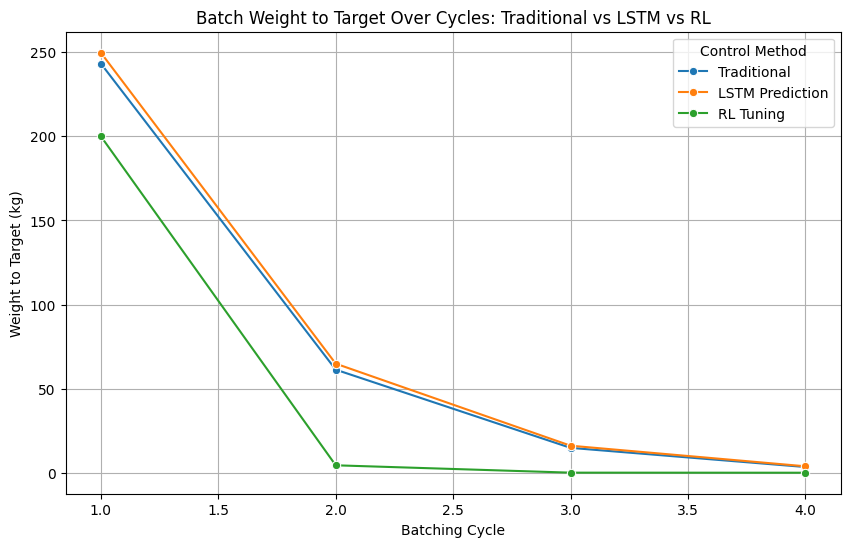

In [155]:
# Cell 12: Plot weight to target over batching cycles for each method

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_comparison, x='Cycle', y='Weight to Target (kg)', hue='Method', marker='o')
plt.title('Batch Weight to Target Over Cycles: Traditional vs LSTM vs RL')
plt.xlabel('Batching Cycle')
plt.ylabel('Weight to Target (kg)')
plt.grid(True)
plt.legend(title='Control Method')
plt.show()


**7.3 Notebook Cell: Summary Table of Final Errors and Efficiency**

In [156]:
# Cell 13: Summarize final weight errors and gate open times for comparison

final_errors = {
    'Method': ['Traditional', 'LSTM Prediction', 'RL Tuning'],
    'Final Weight to Target (kg)': [
        df_traditional_equal['Weight to Target (kg)'].iloc[-1],
        df_lstm_equal['Weight to Target (kg)'].iloc[-1],
        df_rl_equal['Weight to Target (kg)'].iloc[-1]
    ],
    'Total Gate Open Time (s)': [
        sum(df_traditional_equal['Cycle'].apply(lambda c: simulation_results['equal_flow_rate'][c-1]['Gate Open Time (s)'])),
        sum(df_lstm_equal['Cycle'].apply(lambda c: intelligent_results[c-1]['Gate Open Time (s)'])),
        sum(df_rl_equal['Cycle'].apply(lambda c: rl_results[c-1]['Gate Open Time (s)']))
    ]
}

df_summary = pd.DataFrame(final_errors)
print("Summary of Final Weight Errors and Total Gate Open Times:")
print(df_summary)


Summary of Final Weight Errors and Total Gate Open Times:
            Method  Final Weight to Target (kg)  Total Gate Open Time (s)
0      Traditional                         3.39                179.890000
1  LSTM Prediction                         3.82                179.819997
2        RL Tuning                         0.00                150.720000


**Testing and Extending the Batching Control Simulation with Actual Plant Data**

This section provides new notebook cells to test the batching control models using  attached real plant data (BIN_01.csv, BIN_02.csv, BIN_03.csv). The workflow includes loading the actual data, running the traditional, LSTM, and RL-based simulations, and visualizing the results for further evaluation and improvement.

**8. Data Loading and Preparation**

In [157]:
# Load CSV files for aggregate bins
bin_01 = pd.read_csv('BIN_01.csv')
bin_02 = pd.read_csv('BIN_02.csv')
bin_03 = pd.read_csv('BIN_03.csv')

# Extract flow rates (convert units if necessary)
actual_flows_bin_01 = bin_01['Flow Rate'].values / 10
actual_flows_bin_02 = bin_02['Flow Rate'].values / 10
actual_flows_bin_03 = bin_03['Flow Rate'].values / 10

print("Data loaded for BIN_01, BIN_02, BIN_03.")


Data loaded for BIN_01, BIN_02, BIN_03.


**9.1 Adaptive Traditional Batching Function**

In [158]:
def traditional_batching_adaptive_simulation(target_weight, initial_estimated_flow, actual_flows, num_cycles=4, correction_factor=0.75):
    results = []
    cumulative_weight = 0
    estimated_flow = initial_estimated_flow
    for cycle in range(1, num_cycles + 1):
        weight_error = (target_weight - cumulative_weight) * correction_factor
        gate_open_time = weight_error / estimated_flow if estimated_flow != 0 else 0
        # Use the actual flow for the current cycle
        actual_flow = actual_flows[cycle - 1]
        actual_weight_added = actual_flow * gate_open_time
        cumulative_weight += actual_weight_added
        expected_weight_added = estimated_flow * gate_open_time
        flow_rate_correction = actual_weight_added - expected_weight_added
        estimated_flow += flow_rate_correction / gate_open_time if gate_open_time != 0 else 0
        remaining_weight = target_weight - cumulative_weight
        results.append({
            'Cycle': cycle,
            'Weight Error (kg)': round(weight_error, 2),
            'Gate Open Time (s)': round(gate_open_time, 2),
            'Actual Weight Added (kg)': round(actual_weight_added, 2),
            'Cumulative Weight (kg)': round(cumulative_weight, 2),
            'Flow Rate Correction (kg/s)': round(flow_rate_correction / gate_open_time if gate_open_time != 0 else 0, 2),
            'Estimated Flow Rate (kg/s)': round(estimated_flow, 2),
            'Remaining Weight (kg)': round(remaining_weight, 2)
        })
    return pd.DataFrame(results)

**9.2 Run Traditional Simulation Example (BIN_01)**

In [159]:
target_weight = 1000
initial_estimated_flow_bin_01 = 5.5  # Example initial estimate

df_traditional_bin_01 = traditional_batching_adaptive_simulation(
    target_weight,
    initial_estimated_flow_bin_01,
    actual_flows_bin_01[0:num_cycles],
    num_cycles=4
)

print(df_traditional_bin_01)

   Cycle  Weight Error (kg)  Gate Open Time (s)  Actual Weight Added (kg)  \
0      1             750.00              136.36                    681.82   
1      2             238.64               47.73                    159.09   
2      3             119.32               35.80                    178.98   
3      4             -14.91               -2.98                    -23.86   

   Cumulative Weight (kg)  Flow Rate Correction (kg/s)  \
0                  681.82                        -0.50   
1                  840.91                        -1.67   
2                 1019.89                         1.67   
3                  996.02                         3.00   

   Estimated Flow Rate (kg/s)  Remaining Weight (kg)  
0                        5.00                 318.18  
1                        3.33                 159.09  
2                        5.00                 -19.89  
3                        8.00                   3.98  


**10. LSTM-Based Flow Prediction and Simulation**

**10.1 Prepare Data for LSTM Model**

In [160]:
# Scale flow rate data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
flow_series = actual_flows_bin_01.reshape(-1, 1)
flow_series_scaled = scaler.fit_transform(flow_series)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 2
X, y = create_sequences(flow_series_scaled, seq_length)


**10.2 Build and Train LSTM Model**

In [161]:
model_lstm = Sequential([
    LSTM(32, input_shape=(seq_length, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=100, batch_size=2, verbose=0)

print("LSTM model trained.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


LSTM model trained.


**10.3 LSTM-Enhanced Batching Simulation**

In [162]:
def intelligent_batching_simulation(lstm_model, scaler, initial_flows, target_weight=1000, num_cycles=4, seq_length=2):
    results = []
    cumulative_weight = 0
    flow_history = list(initial_flows[:seq_length])
    for i in range(num_cycles):
        input_seq = scaler.transform(np.array(flow_history[-seq_length:]).reshape(-1, 1)).reshape(1, seq_length, 1)
        predicted_scaled = lstm_model.predict(input_seq, verbose=0)
        predicted_flow = scaler.inverse_transform(predicted_scaled)[0][0]
        weight_error = (target_weight - cumulative_weight) * 0.75
        gate_open_time = weight_error / predicted_flow if predicted_flow != 0 else 0
        actual_flow = initial_flows[i]
        actual_weight_added = actual_flow * gate_open_time
        cumulative_weight += actual_weight_added
        weight_to_target = target_weight - cumulative_weight
        results.append({
            'Cycle': i + 1,
            'LSTM Predicted Flow (kg/s)': round(predicted_flow, 2),
            'Weight Error (kg)': round(weight_error, 2),
            'Gate Open Time (s)': round(gate_open_time, 2),
            'Actual Weight Added (kg)': round(actual_weight_added, 2),
            'Cumulative Weight (kg)': round(cumulative_weight, 2),
            'Weight to Target (kg)': round(weight_to_target, 2)
        })
        flow_history.append(actual_flow)
    return pd.DataFrame(results)

df_lstm_bin_01 = intelligent_batching_simulation(model_lstm, scaler, actual_flows_bin_01, target_weight, num_cycles=4, seq_length=seq_length)
print(df_lstm_bin_01)


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  
/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  


   Cycle  LSTM Predicted Flow (kg/s)  Weight Error (kg)  Gate Open Time (s)  \
0      1                       12.10             750.00           61.970001   
1      2                       11.67             517.61           44.340000   
2      3                       12.10             406.76           33.610000   
3      4                       11.67             280.72           24.050000   

   Actual Weight Added (kg)  Cumulative Weight (kg)  Weight to Target (kg)  
0                    309.85                  309.85                 690.15  
1                    147.81                  457.66                 542.34  
2                    168.05                  625.70                 374.30  
3                    192.39                  818.09                 181.91  


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py:315: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  


**11. Reinforcement Learning (RL) Controller Self-Tuning**

**11.1 Define RL Environment**

In [163]:
class DiscreteBatchingEnv(gym.Env):
    def __init__(self, actual_flows, target_weight=1000, num_cycles=4):
        super().__init__()
        self.actual_flows = actual_flows
        self.target_weight = target_weight
        self.num_cycles = num_cycles
        self.current_cycle = 0
        self.cumulative_weight = 0
        self.action_space = spaces.Discrete(6)
        self.correction_factors = np.linspace(0.5, 1.0, 6)
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([num_cycles, target_weight, 10]),
            dtype=np.float32
        )

    def reset(self, seed=None, options=None): # Added seed and options parameters
        super().reset(seed=seed) # Added super().reset()
        self.current_cycle = 0
        self.cumulative_weight = 0
        self.last_flow = self.actual_flows[0]
        return np.array([self.current_cycle, self.cumulative_weight, self.last_flow], dtype=np.float32), {} # Added info dictionary

    def step(self, action):
        correction_factor = self.correction_factors[action]
        weight_error = (self.target_weight - self.cumulative_weight) * correction_factor
        gate_open_time = weight_error / self.last_flow if self.last_flow != 0 else 0
        actual_flow = self.actual_flows[self.current_cycle]
        actual_weight_added = actual_flow * gate_open_time
        self.cumulative_weight += actual_weight_added
        self.current_cycle += 1
        done = self.current_cycle >= self.num_cycles
        reward = -abs(self.target_weight - self.cumulative_weight)
        obs = np.array([self.current_cycle, self.cumulative_weight, actual_flow], dtype=np.float32)
        self.last_flow = actual_flow
        return obs, reward, done, False, {} # Added truncated and info dictionary

# Instantiate environment for BIN_01
rl_env_bin_01 = DiscreteBatchingEnv(actual_flows=actual_flows_bin_01, target_weight=target_weight, num_cycles=4)

**11.2 Train RL Agent**

In [164]:
model_rl_bin_01 = DQN('MlpPolicy', rl_env_bin_01, verbose=0)
model_rl_bin_01.learn(total_timesteps=2000)

print("RL agent trained.")


RL agent trained.


**11.3 RL-Based Batching Simulation**

In [165]:
def rl_batching_simulation(model, env, initial_flows, num_cycles=4):
    obs, _ = env.reset() # Unpack the observation
    results = []
    for i in range(num_cycles):
        action, _ = model.predict(obs, deterministic=True)
        correction_factor = env.correction_factors[action]
        weight_error = (env.target_weight - env.cumulative_weight) * correction_factor
        gate_open_time = weight_error / env.last_flow if env.last_flow != 0 else 0
        actual_flow = initial_flows[i]
        actual_weight_added = actual_flow * gate_open_time
        env.cumulative_weight += actual_weight_added
        weight_to_target = env.target_weight - env.cumulative_weight
        results.append({
            'Cycle': i + 1,
            'RL Correction Factor': round(correction_factor, 2),
            'Weight Error (kg)': round(weight_error, 2),
            'Gate Open Time (s)': round(gate_open_time, 2),
            'Actual Weight Added (kg)': round(actual_weight_added, 2),
            'Cumulative Weight (kg)': round(env.cumulative_weight, 2),
            'Weight to Target (kg)': round(weight_to_target, 2)
        })
        obs, _, done, _, _ = env.step(action) # Unpack the observation, reward, truncated, and info dictionary
        if done:
            break
    return pd.DataFrame(results)

df_rl_bin_01 = rl_batching_simulation(model_rl_bin_01, rl_env_bin_01, actual_flows_bin_01, num_cycles=4)
print(df_rl_bin_01)

   Cycle  RL Correction Factor  Weight Error (kg)  Gate Open Time (s)  \
0      1                   1.0             1000.0               200.0   
1      2                   0.9                0.0                 0.0   
2      3                   0.9                0.0                 0.0   
3      4                   0.9                0.0                 0.0   

   Actual Weight Added (kg)  Cumulative Weight (kg)  Weight to Target (kg)  
0                    1000.0                  1000.0                    0.0  
1                       0.0                  1000.0                    0.0  
2                       0.0                  1000.0                    0.0  
3                       0.0                  1000.0                    0.0  


**12. Comparative Analysis and Visualization**

**12.1 Prepare Data for Comparison**

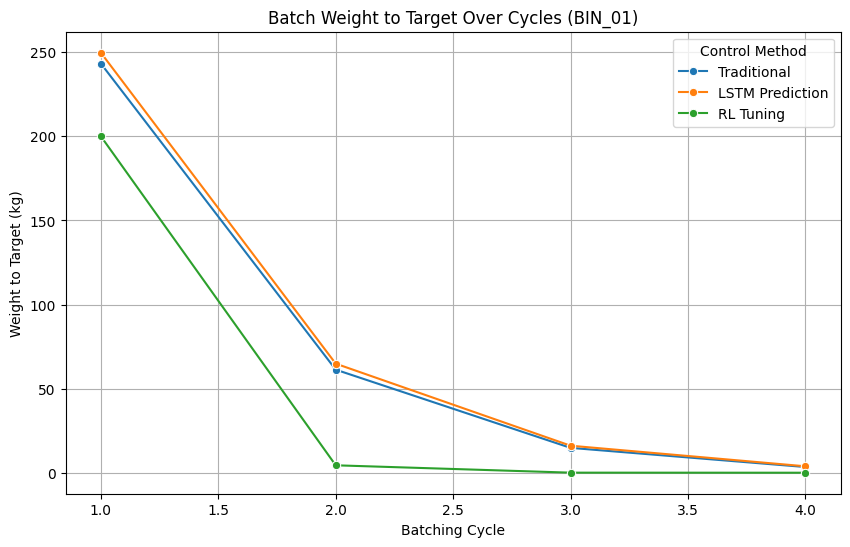

In [166]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_comparison, x='Cycle', y='Weight to Target (kg)', hue='Method', marker='o')
plt.title('Batch Weight to Target Over Cycles (BIN_01)')
plt.xlabel('Batching Cycle')
plt.ylabel('Weight to Target (kg)')
plt.grid(True)
plt.legend(title='Control Method')
plt.show()



**12.3 Summary Table of Final Errors and Efficiency**

In [167]:
summary = {
    'Method': ['Traditional', 'LSTM Prediction', 'RL Tuning'],
    'Final Weight to Target (kg)': [
        df_traditional_bin_01['Remaining Weight (kg)'].iloc[-1],
        df_lstm_bin_01['Weight to Target (kg)'].iloc[-1],
        df_rl_bin_01['Weight to Target (kg)'].iloc[-1]
    ],
    'Total Gate Open Time (s)': [
        df_traditional_bin_01['Gate Open Time (s)'].sum(),
        df_lstm_bin_01['Gate Open Time (s)'].sum(),
        df_rl_bin_01['Gate Open Time (s)'].sum()
    ]
}
df_summary = pd.DataFrame(summary)
print("Summary of Final Weight Errors and Total Gate Open Times:")
print(df_summary)


Summary of Final Weight Errors and Total Gate Open Times:
            Method  Final Weight to Target (kg)  Total Gate Open Time (s)
0      Traditional                         3.98                216.910000
1  LSTM Prediction                       181.91                163.970001
2        RL Tuning                         0.00                200.000000
